In [1]:
###################Calculating district cumulative rainfall and plotting it##################
import geopandas as gpd
import regionmask 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import netCDF4 as nc
import datetime as dt
import pandas as pd
                                       # State mask variable

In [16]:
######################Specify the parameters######################################
####Specify year and day
year=2020
f1_name='/mnt/rc/IMD_rainfall_0.25/_Clim_Pred_LRF_New_RF25_IMD0p252020.nc'    #Specify file name accordingly
st_date=dt.datetime(year,7,15,0,0)                                   #Give necessary day here (year, month,day)

fname='/mnt/rc/All Shape File/Kerala district shape file/Kerala districtshape file.shp'           # District shapefile of kerala
data = pd.read_csv('Grid_District_Contribution.csv')                                              # Load the percent mask file

####Label Bar Settings
label_cbar= "District Cumulative Rainfall (mm)"               # Give the label for colorbar
min_cbar=0.0                                                         # Minimum for colorbar
max_cbar=600                                                         # Maximum for colorbar
level_cbar=40                                                        # No. of levels for colorbar

img_name='district_cumulative_rf_daily_percent_mask.png'                # Give the name for saving the image

####Annotation Color
annot_color='yellow'                                                   # Color for annotation of district name in plot

#####Colorbar for plot
cmap='RdBu'                                                          # Specify the colorbar for plot


In [3]:
#####################read the rainfall data file needed to plot###############################
f1 = nc.Dataset(f1_name)
rf_fill=f1.variables['RAINFALL']
for var in f1.variables.values():
    print(var)                                                       # Print Metadata for all variables

lats = f1.variables['LATITUDE'][:]
lons = f1.variables['LONGITUDE'][:]
time = f1.variables['TIME']

lat_size=len(lats)
lon_size=len(lons)


<class 'netCDF4._netCDF4.Variable'>
float64 LONGITUDE(LONGITUDE)
    units: degrees_east
    point_spacing: even
    axis: X
    modulo: 360.0
    standard_name: longitude
unlimited dimensions: 
current shape = (135,)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float64 LATITUDE(LATITUDE)
    units: degrees_north
    point_spacing: even
    axis: Y
    standard_name: latitude
unlimited dimensions: 
current shape = (129,)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float64 TIME(TIME)
    units: days since 1900-12-31 00:00:00
    axis: T
    calendar: GREGORIAN
    time_origin: 31-DEC-1900
    standard_name: time
unlimited dimensions: TIME
current shape = (366,)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float32 RAINFALL(TIME, LATITUDE, LONGITUDE)
    missing_value: -999.0
    _FillValue: -999.0
    long_name: Rainfall
    units

/home/lekshmi/anaconda3/envs/pyn_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  """


In [4]:
####################################Subsetting over time#####################################
iday=nc.date2index(st_date,time,calendar='standard',select='exact')  #Gives us index of necessary day
rf_day=f1.variables['RAINFALL'][iday,:,:]     # Reading for required day and lat lon range

/home/lekshmi/anaconda3/envs/pyn_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  


In [5]:
#########################Read the shape file and create masks###############################

shp=gpd.read_file(fname)
print(shp['DISTRICT_1'])
dist_name=list(shp['DISTRICT_1'])
dist_1=list(shp['DISTRICT_1'])
indexes=[dist_name.index(x) for x in dist_1]                             # Obtain district indexes

dist1=regionmask.Regions(outlines=list(shp.geometry.values[i] for i in range(0, shp.shape[0])), names=shp.DISTRICT_1[indexes],abbrevs=shp.DISTRICT_1[indexes],name='district', )   # Obtaining region boundaries
dist1_mask=dist1.mask(lons,lats)   

0              ALAPPUZHA
1              ERNAKULAM
2                 IDUKKI
3                 KANNUR
4               KASARGOD
5                 KOLLAM
6               KOTTAYAM
7              KOZHIKODE
8             MALAPPURAM
9               PALAKKAD
10        PATHANAMTHITTA
11    THIRUVANANTHAPURAM
12              THRISSUR
13               WAYANAD
Name: DISTRICT_1, dtype: object


In [6]:
#######################Read the percentage mask file#################################
district=data['District'][:]
lat=data['Lat'][:]
lon=data['Lon'][:]
area=data['Area'][:]
percent=data['Percent Contribution'][:]


In [7]:

Dist_avg_rf=np.full(len(dist_1),rf_fill._FillValue, order='C')

for i in range(0,len(dist_1)):
    lat_percent=(lat[dist_name[i] == district]).tolist()
    lon_percent=(lon[dist_name[i] == district]).tolist()
    percent_mask=(percent[dist_name[i] == district]).tolist()
    Total=0.0
    #print(dist_name[i])
    for j in range (0, len(lat_percent)):
        ind_lat_rf=np.where(lats == lat_percent[j])
        ind_lon_rf=np.where(lons == lon_percent[j])
        #print(Total)
        Total=Total+rf_day[ind_lat_rf,ind_lon_rf]*percent_mask[j]
        #print(Total, "   ",percent_mask[j])
        
    Dist_avg_rf[i]=Total
    del Total
    del lat_percent
    del lon_percent
    del percent_mask
    
print(Dist_avg_rf)

[ 83.44886     2.3271656  49.406223  344.34402   581.12146    15.8297205
   2.705662  185.45526   162.81543   242.19405     5.486354    0.
  46.94205   135.54033  ]


In [8]:
#################Create a merged geodataframe with values and geometry#########################    
d={'ID':list(shp['ID']),'Rainfall':Dist_avg_rf}     #Create a rainfall datatframe
data_f=pd.DataFrame(data=d)

df_merged = shp.merge(data_f, left_on='ID', right_on='ID') #Merge it with shapefile to create geodataframe to plot

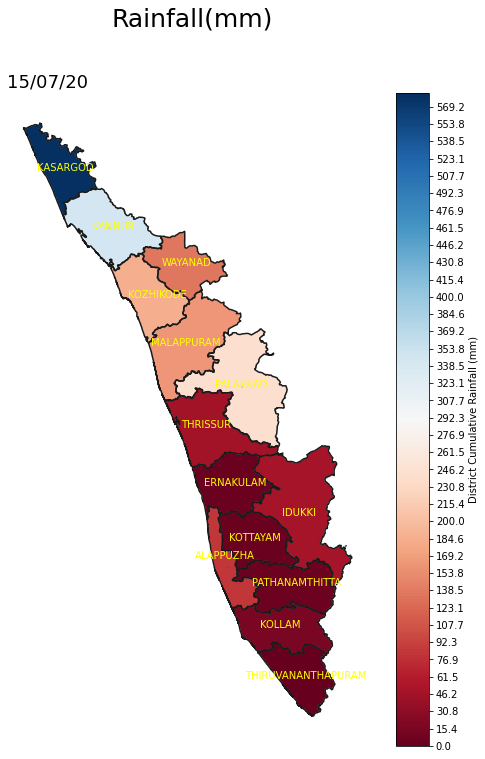

In [17]:
####################################Plot Settings#############################################
date_string=st_date.strftime("%d/%m/%y")
fig, ax = plt.subplots(1, figsize=(10,12))
df_merged.plot(column='Rainfall',cmap=cmap, linewidth=1, ax=ax, edgecolor='0.9', legend = False) 
ax.axis('off')
fig.suptitle('Rainfall(mm)',fontsize=25)
ax.set_title(date_string, fontsize=18, loc='Left')

#####################Giving labels to each district##########################################
df_merged['coords'] = df_merged['geometry'].apply(lambda x: x.representative_point().coords[:])
df_merged['coords'] = [coords[0] for coords in df_merged['coords']]
for idx, row in df_merged.iterrows():
    plt.annotate(text=row['DISTRICT_1'], xy=row['coords'],horizontalalignment='center',color=annot_color)     # To give name of district
    #plt.annotate(s=row['Rainfall'], xy=row['coords'],horizontalalignment='center')       # To give value of district average rainfall
plt.colorbar(ax.collections[0],ticks=np.linspace(min_cbar,max_cbar,num=level_cbar), label=label_cbar)

text_kws = dict(bbox=dict(color="none"),path_effects=[pe.withStroke(linewidth=0, foreground="w")], color="#67000d",fontsize=0,)
dist1.plot_regions(ax=ax,text_kws=text_kws)
#################################Save the figure############################################
plt.savefig(img_name)
    